In [1]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
tokenized_context = tokenizer('This is return_offsets_mapping example', return_offsets_mapping=True)
print(tokenized_context)

{'input_ids': [101, 2023, 2003, 2709, 1035, 16396, 2015, 1035, 12375, 2742, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'offset_mapping': [(0, 0), (0, 4), (5, 7), (8, 14), (14, 15), (15, 21), (21, 22), (22, 23), (23, 30), (31, 38), (0, 0)]}


In [2]:
import json

def load_data(json_file):
    with open(json_file, 'r', encoding='utf-8') as f:
        squad_data = json.load(f)
    return squad_data

squad_data = load_data('train-v2.0.json')

In [3]:
from transformers import BertTokenizerFast

class SquadProcessor:
    def __init__(self, squad_data, tokenizer_model):
        # 初始化SquadProcessor類，設定資料和tokenizer
        self.squad_data = squad_data
        self.tokenizer = BertTokenizerFast.from_pretrained(tokenizer_model)
    
    def process_answers(self, answers, context, question, csv_data):
        # 處理每個答案，將答案和其在context中的位置轉換為token索引
        for answer in answers:
            answer_text = answer['text']
            answer_start = answer['answer_start']
            answer_end = answer_start + len(answer_text)
            # 將context進行token化並獲取偏移映射
            tokenized_context = self.tokenizer(context, return_offsets_mapping=True)
            # 找到答案的token索引
            start_token_idx, end_token_idx = self.find_token_indices(tokenized_context, answer_start, answer_end)
            
            if start_token_idx is not None and end_token_idx is not None:
                # 將結果追加到csv資料中
                csv_data.append([context, question, answer_text, start_token_idx, end_token_idx])
    
    def find_token_indices(self, tokenized_context, answer_start, answer_end):
        # 找到答案在tokenized context中的起始和結束token索引
        start_token_idx = None
        end_token_idx = None
        for idx, (start, end) in enumerate(tokenized_context['offset_mapping']):
            if start == answer_start:
                start_token_idx = idx
            if end == answer_end:
                end_token_idx = idx
        return start_token_idx, end_token_idx
    
    def parse_data(self):
        # 解析SQuAD資料，將處理過的結果存入csv_data
        csv_data = []
        for article in self.squad_data['data']:
            for paragraph in article['paragraphs']:
                context = paragraph['context']
                for qa in paragraph['qas']:
                    question = qa['question']
                    is_impossible = qa['is_impossible']
                    if not is_impossible:
                        # 若問題有答案，處理答案
                        self.process_answers(qa['answers'], context, question, csv_data)
                    else:
                        # 若問題無法回答，追加空的答案資訊
                        csv_data.append([context, question, '', -1, -1])
        return csv_data

squad_processor = SquadProcessor(squad_data, 'bert-base-uncased')
csv_data = squad_processor.parse_data()
column_names = ['文章內容', '問題', '答案', 'Token起始位子', 'Token結尾位子']
first_row = csv_data[0]
for name, value in zip(column_names, first_row):
    print(f'{name}: {value}')


Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


文章內容: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
問題: When did Beyonce start becoming popular?
答案: in the late 1990s
Token起始位子: 67
Token結尾位子: 70


In [4]:
import pandas as pd

def save_to_csv(csv_data, output_file):
    df = pd.DataFrame(csv_data, columns=['context', 'question', 'answer', 'start_token_idx', 'end_token_idx'])
    df.to_csv(output_file, index=False, encoding='utf-8')

# 儲存至 CSV 檔案
save_to_csv(csv_data, 'squad2.0_converted.csv')

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 讀取CSV檔案並只選取指定的4個欄位
df = pd.read_csv('squad2.0_converted.csv', usecols=['context', 'question', 'answer', 'start_token_idx', 'end_token_idx'])

train_df, valid_df = train_test_split(df, train_size=0.8, random_state=46, shuffle=True)

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

# 定義自定義Dataset
class SquadDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        item = self.dataframe.iloc[index]
        return item['context'], item['question'], item['start_token_idx'], item['end_token_idx']
       
    def __len__(self):
        return len(self.dataframe)
    
    def collate_fn(self, batch):
        batch_contexts, batch_questions, batch_starts, batch_ends = zip(*batch)
        encodings = self.tokenizer(
            batch_contexts,
            batch_questions,
            truncation=True,
            padding='longest',
            max_length=512,
            return_tensors='pt'
        )

        return {
            **encodings,   # input_ids, attention_mask, token_type_ids
            'start_positions': torch.tensor(batch_starts),
            'end_positions': torch.tensor(batch_ends)
        }

# 建立資料集
trainset = SquadDataset(train_df, tokenizer)
validset = SquadDataset(valid_df, tokenizer)

# 創建DataLoader
train_loader = DataLoader(trainset, batch_size=16, shuffle=True, collate_fn=trainset.collate_fn)
valid_loader = DataLoader(validset, batch_size=16, shuffle=True, collate_fn=validset.collate_fn)

In [7]:
from transformers import BertForQuestionAnswering
import torch.optim as optim
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup

# 訓練設置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 加載BERT模型
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

optimizer = optim.AdamW(model.parameters(), lr=2e-4)
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=len(train_loader) * 0.2, 
        num_training_steps=len(train_loader) * 10, 
        num_cycles=1, 
)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6506 [00:00<?, ?it/s]c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Valid Epoch 0: 100%|██████████| 1627/1627 [01:01<00:00, 26.31it/s, loss=2.132]


Saving Model With Loss 1.82464
Train Loss: 1.97271| Valid Loss: 1.82464| Best Loss: 1.82464



Valid Epoch 1: 100%|██████████| 1627/1627 [01:00<00:00, 26.77it/s, loss=1.248]


Saving Model With Loss 1.65771
Train Loss: 1.75430| Valid Loss: 1.65771| Best Loss: 1.65771



Valid Epoch 2: 100%|██████████| 1627/1627 [01:02<00:00, 26.17it/s, loss=1.650]


Saving Model With Loss 1.49451
Train Loss: 1.41072| Valid Loss: 1.49451| Best Loss: 1.49451



Valid Epoch 3: 100%|██████████| 1627/1627 [01:01<00:00, 26.27it/s, loss=2.490]


Saving Model With Loss 1.44374
Train Loss: 1.18482| Valid Loss: 1.44374| Best Loss: 1.44374



Valid Epoch 4: 100%|██████████| 1627/1627 [01:02<00:00, 25.92it/s, loss=1.036]


Saving Model With Loss 1.40408
Train Loss: 0.91828| Valid Loss: 1.40408| Best Loss: 1.40408



Valid Epoch 5: 100%|██████████| 1627/1627 [01:02<00:00, 26.08it/s, loss=1.654]


Train Loss: 0.65847| Valid Loss: 1.57564| Best Loss: 1.40408



Valid Epoch 6: 100%|██████████| 1627/1627 [01:02<00:00, 26.00it/s, loss=1.061]


Train Loss: 0.42023| Valid Loss: 1.69944| Best Loss: 1.40408



Valid Epoch 7: 100%|██████████| 1627/1627 [01:02<00:00, 26.04it/s, loss=0.439]


------------------------------------
|Model can't improve, stop training|
------------------------------------


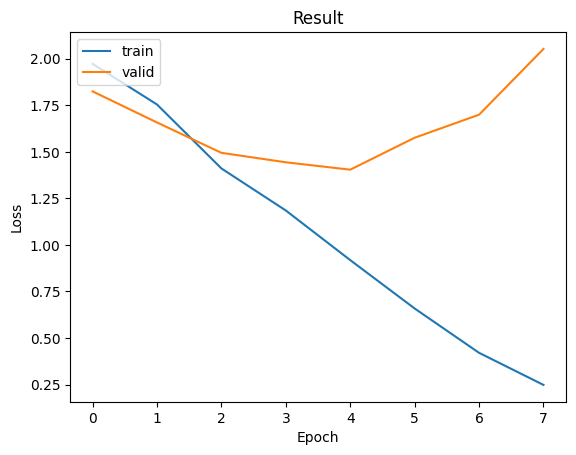

In [8]:
from trainer import Trainer
trainer = Trainer(
    epochs=10, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    model=model, 
    optimizer=[optimizer],
    scheduler=[scheduler],
    early_stopping=3
)
trainer.train()

In [9]:
model.load_state_dict(torch.load('model.ckpt'))
model.eval()

# 從valid_df中獲取context和question
context, question, tgt_answer, start, end = valid_df.values[5]
inputs = tokenizer(
    context,
    question,
    truncation=True,
    padding='longest',
    max_length=512,
    return_tensors='pt'
).to(device)

# 進行推理
with torch.no_grad():
    outputs = model(**inputs)
    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

# 提取答案
start_index = torch.argmax(start_scores)
end_index = torch.argmax(end_scores)

# 確保end_index在start_index之後
if start_index <= end_index:
    answer_tokens = inputs['input_ids'][0][start_index:end_index + 1]
    answer = tokenizer.decode(answer_tokens)
else:
    answer = "Unable to find a valid answer."

# 輸出答案
print('文章內容:', context)
print('問題', question)
print("答案:", tgt_answer)
print("模型答案:", answer)

文章內容: Photo Gallery is an optional application to view, create and group photos from PS3, which is installed separately from the system software at 105 MB. It was introduced in system software version 2.60 and provides a range of tools for sorting through and displaying the system's pictures. The key feature of this application is that it can organize photos into groups according to various criteria. Notable categorizations are colors, ages, or facial expressions of the people in the photos. Slideshows can be viewed with the application, along with music and playlists. The software was updated with the release of system software version 3.40 allowing users to upload and browse photos on Facebook and Picasa.
問題 Is Video Gallery automatically or separately installed?
答案: nan
模型答案: separately


In [10]:
from tqdm import tqdm

def calculate_accuracy(validset, valid_loader, model, device):
    correct = 0
    model.eval()
    for input_datas in tqdm(valid_loader):
        input_datas = {k:v.to(device) for k,v in input_datas.items()}
        tgt_start = input_datas['start_positions']
        tgt_end = input_datas['end_positions']
        # 進行推論
        with torch.no_grad():
            outputs = model(**input_datas)
            start_scores = outputs.start_logits
            end_scores = outputs.end_logits
        # 提取答案索引
        start_index = torch.argmax(start_scores, dim=1)
        end_index = torch.argmax(end_scores, dim=1)

        # 檢查索引是否與目標索引匹配
        correct += ((start_index == tgt_start) & (end_index == tgt_end)).sum().item()
    
    accuracy = correct / len(validset)
    return accuracy

# 使用valid_loader來計算準確率
accuracy = calculate_accuracy(validset, valid_loader, model, device)
print(f'模型準確率: {accuracy:.2%}')

100%|██████████| 1627/1627 [01:01<00:00, 26.53it/s]

模型準確率: 44.50%
